# Computing the threshold of the surface code

In this tutorial, we will show to compute the code-capacity threshold of the 2D surface using PanQEC.

In [1]:
from tqdm.notebook import tqdm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from panqec.simulation import read_input_dict
from panqec.analysis import Analysis

## Running the simulations

We first provide the dictionary:

In [2]:
input_data = {
    'ranges': {
        'label': 'Toric 2D Experiment',  # Can be any name you want
        'code': {
            'name': 'Toric2DCode',  # Class name of the code
            'parameters': [
                {'L_x': 10},
                {'L_x': 20},
                {'L_x': 30},
            ]
        },
        'error_model': {
            'name': 'PauliErrorModel',  # Class name of the error model
            'parameters': [
                {'r_x': 1/3, 'r_y': 1/3, 'r_z': 1/3}  # Ratios of X, Y and Z errors
            ],
        },
        'decoder': {
            'name': 'MatchingDecoder',  # Class name of the decoder
            'parameters': [{}]
        },
        'error_rate': np.linspace(0.1, 0.2, 10).tolist()  # List of physical error rates
    }
}

We now load the input dictionary using the function `read_input_dict`. It returns an instance of `BatchSimulation` from which we can run our simulations with the specified parameters.

In [3]:
plot_frequency = 20  # Frequency of plot update
save_frequency = 10  # Frequency of saving to file
n_trials = 2000  # Target number of Monte Carlo runs

# We create a BatchSimulation by reading the input dictionary
batch_sim = read_input_dict(
    input_data,
    output_file='toric-2d-results.json',  # Where to store the simulation results
    update_frequency=plot_frequency,
    save_frequency=save_frequency
)

# Live update of the plot during the simulation
# (only works in Jupyter notebooks)
batch_sim.activate_live_update()

Start batch simulation instance


We now run the experiment. It should plot the new curve every 20 iterations (`plot_frequency`), and save the results to a file (contained by default in the `temp/` folder) every 10 iterations (`save_frequency`). If you interrupt the simulation or destroy the notebook kernel, it should restart from the last saved results. So feel free to interrupt the cell once you're satisfied with the results.

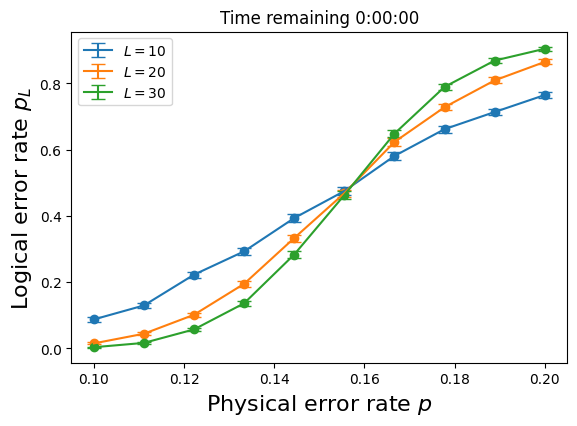

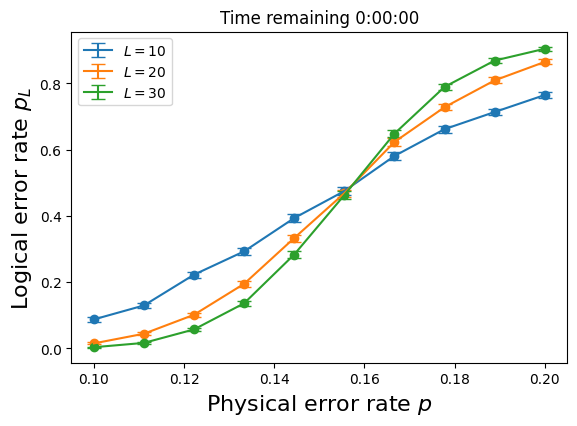

In [4]:
batch_sim.run(n_trials, progress=tqdm)

## Analyzing the results

We can now analyze the results using the `Analysis` class. The threshold is computed using a common finite-size scaling regression analysis. The simulation data is fitted to
the following ansatz for the logical error rate $p_L(p, L)$ as a function
of the physical error rate $p$ and system size $L$.

$$
\begin{align}
    p_L &= A + Bx + Cx^2, \\
    x &= (p-p_{\text{th}}) L^{1/\nu},
\end{align}
$$

where $p_{\text{th}}$ is the threshold error rate we seek to evaluate, $\nu$ is a critical exponent, and $A,B,C$ are coefficients of the quadratic ansatz, all of which are free parameters to be determined by fitting to the data.
Here $x$ is termed the *rescaled physical error rate*, which is zero at the phase transition $p=p_{\textrm{th}}$.
That $p_L$ is a quadratic function of $x$ is only expected to be a valid approximation near this phase transition for $x$, so only data points with physical error rates close to the phase transition should be used for an optimal fitting.

In [5]:
analysis = Analysis("toric-2d-results.json")

### Plotting the results

Let's first plot the crossing curves along with the estimated threshold. 

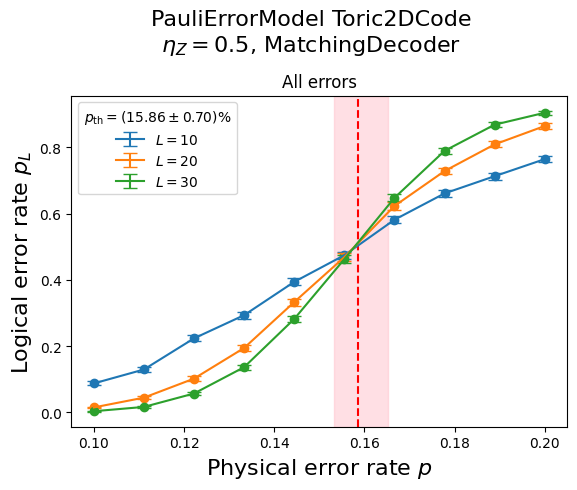

In [6]:
analysis.plot_thresholds()

Sometimes, it is also interesting to look at the thresholds for $X$ and $Z$ errors separately (for instance when the code is asymmetric). You can do this in PanQEC by giving a `sector` argument to `plot_thresholds`:

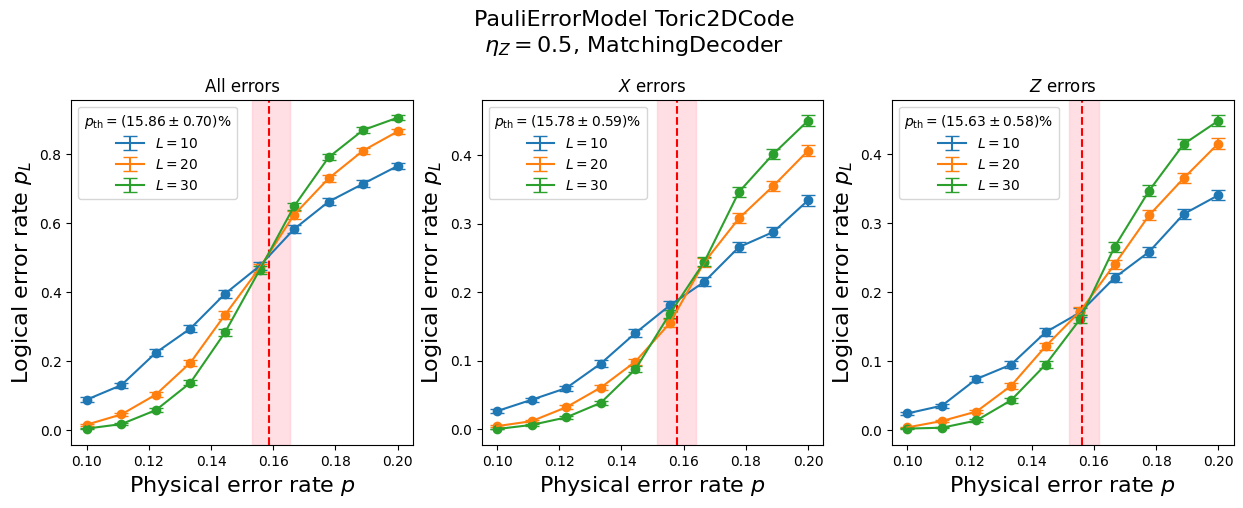

In [7]:
fig, ax = plt.subplots(ncols=3, figsize=(15, 5))

plt.sca(ax[0])
analysis.plot_thresholds()
plt.sca(ax[1])
analysis.plot_thresholds(sector='X')
plt.sca(ax[2])
analysis.plot_thresholds(sector='Z')

If you want more details on how good the fit was when estimating the threshold, you can use the function `make_collapse_plots`.

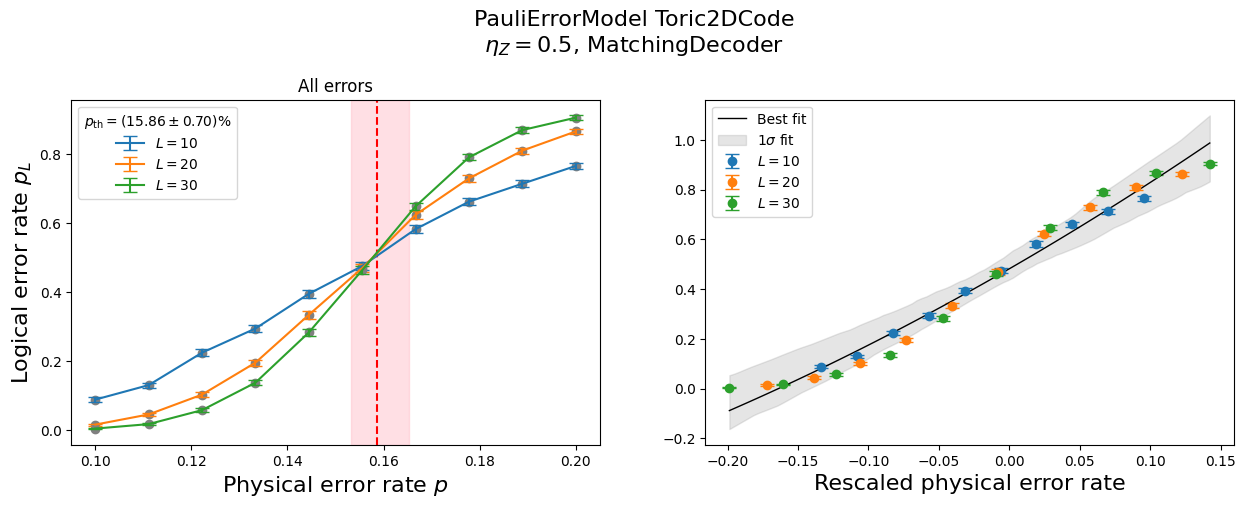

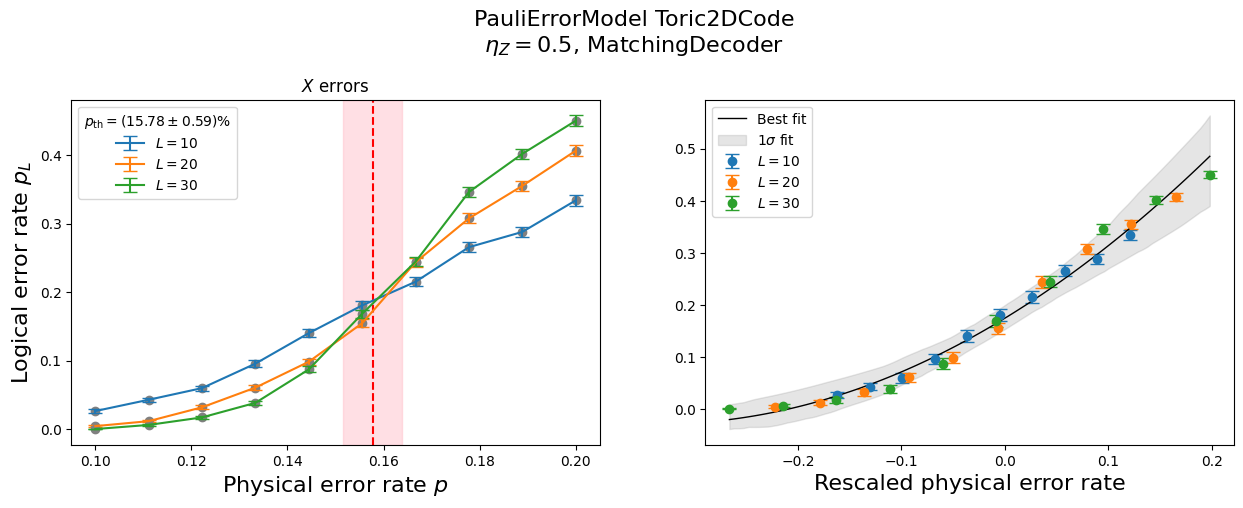

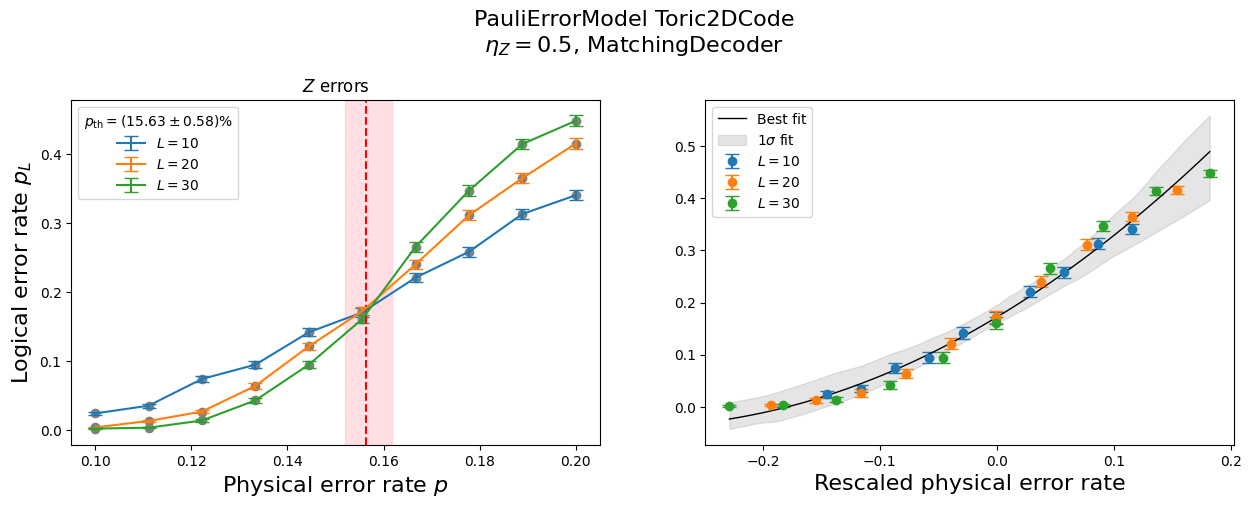

In [8]:
analysis.make_collapse_plots()

## Extracting the data

You might also want to extract the raw data from the simulation. You can do so using `get_results()`, which returns a Pandas dataframe containing all the simulation results. In particular, the column `error_rate` refers to the physical error rate, `p_est` and `p_se` to the logical error rate. More details can be found in the documentation of the `Analysis` class.

In [9]:
results = analysis.get_results()
results[['code', 'decoder', 'd', 'error_rate', 'p_est', 'p_se', 'n_fail', 'n_trials']].head(10)

,code,decoder,d,error_rate,p_est,p_se,n_fail,n_trials
0,Toric2DCode,MatchingDecoder,10,0.100000,0.0875,0.006317,175,2000
1,Toric2DCode,MatchingDecoder,10,0.111111,0.1295,0.007506,259,2000
2,Toric2DCode,MatchingDecoder,10,0.122222,0.2235,0.009313,447,2000
3,Toric2DCode,MatchingDecoder,10,0.133333,0.2935,0.010180,587,2000
4,Toric2DCode,MatchingDecoder,10,0.144444,0.3940,0.010923,788,2000
5,Toric2DCode,MatchingDecoder,10,0.155556,0.4745,0.011163,949,2000
6,Toric2DCode,MatchingDecoder,10,0.166667,0.5815,0.011028,1163,2000
7,Toric2DCode,MatchingDecoder,10,0.177778,0.6610,0.010582,1322,2000
8,Toric2DCode,MatchingDecoder,10,0.188889,0.7130,0.010113,1426,2000
9,Toric2DCode,MatchingDecoder,10,0.200000,0.7645,0.009486,1529,2000


You can also extract information about the thresholds using `analysis.thresholds` and `analysis.sector_thresholds`. Here, the columns `p_th_fss` and `p_th_fss_se` refer to the estimated threshold (using finite-size scaling) and the estimated standard error, while `p_th_fss_left` and `p_th_fss_right` are left and right $1\sigma$ CI bounds on the estimate.

In [10]:
selected_columns = ['code', 'error_model', 'bias', 'p_th_fss', 'p_th_fss_se', 'p_th_fss_left', 'p_th_fss_right']
analysis.thresholds[selected_columns]

,code,error_model,bias,p_th_fss,p_th_fss_se,p_th_fss_left,p_th_fss_right
0,Toric2DCode,PauliErrorModel,0.5,0.158602,0.007047,0.153187,0.165336


In [11]:
analysis.sector_thresholds['X'][selected_columns]

,code,error_model,bias,p_th_fss,p_th_fss_se,p_th_fss_left,p_th_fss_right
0,Toric2DCode,PauliErrorModel,0.5,0.157797,0.005943,0.151524,0.163864


Using those dataframes, you can therefore generate you own custom plots the following way (for instance):

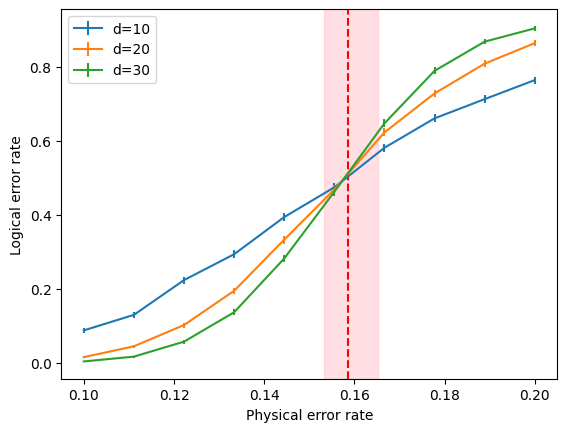

In [12]:
for d in results['d'].unique():
    plt.errorbar(results[results['d'] == d]['error_rate'], 
                 results[results['d'] == d]['p_est'],
                 results[results['d'] == d]['p_se'],
                 label=f'd={d}')

plt.axvline(analysis.thresholds.iloc[0]['p_th_fss'], color='red', linestyle='--')
plt.axvspan(analysis.thresholds.iloc[0]['p_th_fss_left'], analysis.thresholds.iloc[0]['p_th_fss_right'],
            alpha=0.5, color='pink')

plt.xlabel('Physical error rate')
plt.ylabel('Logical error rate')
plt.legend()